In [14]:
import yfinance as yf 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

data = yf.download("BTC-USD",start = '2025-02-01',end='2025-02-28',interval="1h")

data["SMA"] = data["Close"].rolling(window=20,min_periods=20).mean()
data["Std"] = data["Close"].rolling(window=20,min_periods=20).std()
data["Upper"] = data["SMA"]+ 4 * data["Std"]
data["Lower"] = data["SMA"]- 4 * data["Std"]
# Drop NaN values
data = data.dropna()

# Flatten the MultiIndex columns
data.columns = data.columns.get_level_values(0)


[*********************100%***********************]  1 of 1 completed


In [15]:
data["Position"] = 0 

# Loop through data starting at day 20 (when SMA is available)
for t in range(19, len(data)):
    # Current and previous position
    prev_position = data['Position'].iloc[t-1]
    close = data['Close'].iloc[t]
    sma = data['SMA'].iloc[t]
    upper = data['Upper'].iloc[t]
    lower = data['Lower'].iloc[t]
    
    
    if close > lower and prev_position ==0:
        data["Position"].iloc[t] = 1 # Buy signal 
    elif close < upper and prev_position ==1:
        data["Position"].iloc[t] = 0 # Sell signal 
    else:
        data["Position"].iloc[t] = prev_position
    

/var/folders/xb/jvsqhlrj3bn612r38k64z6n40000gn/T/ipykernel_5529/748066717.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["Position"].iloc[t] = 1 # Buy signal
/var/folders/xb/jvsqhlrj3bn612r38k64z6n40000gn/T/ipykernel_5529/74806671

/var/folders/xb/jvsqhlrj3bn612r38k64z6n40000gn/T/ipykernel_5529/3718546233.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Strategy_Return'].iloc[0] = 0
/var/folders/xb/jvsqhlrj3bn612r38k64z6n40000gn/T/ipykernel_5529/3718546233.py:

Total Return: 3.38%
Annualized Return: 1.34%
Annualized Volatility: 6.16%
Sharpe Ratio: 0.22
Maximum Drawdown: -6.75%
Number of Trades: 305


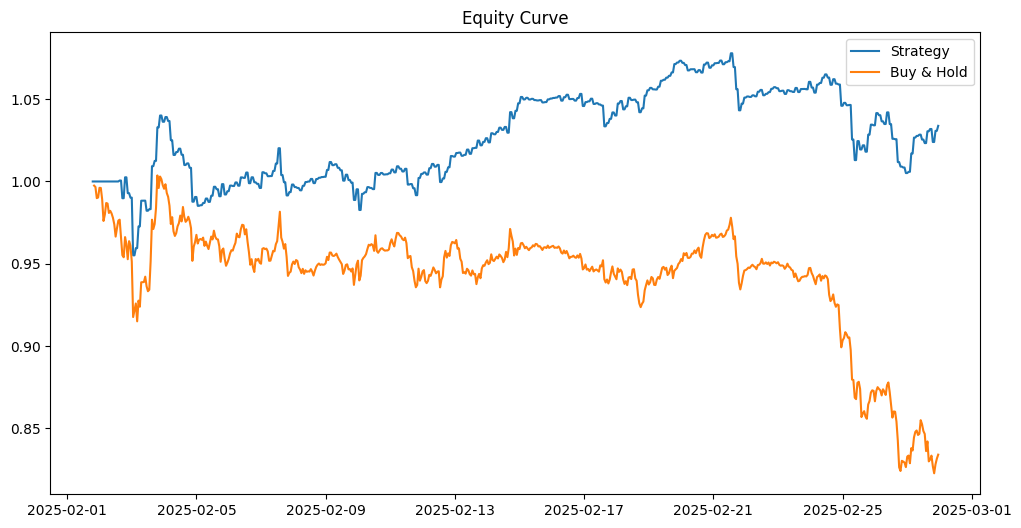

In [16]:
# Backtest
data['Asset_Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Position'].shift(1) * data['Asset_Return']
data['Strategy_Return'].iloc[0] = 0
data['Equity_Curve'] = (1 + data['Strategy_Return']).cumprod()
data['Buy_Hold_Curve'] = (1 + data['Asset_Return']).cumprod()

# Performance metrics
total_return = data['Equity_Curve'].iloc[-1] - 1
days = len(data)
annualized_return = (data['Equity_Curve'].iloc[-1]) ** (252 / days) - 1
annualized_vol = data['Strategy_Return'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_vol
equity_roll_max = data['Equity_Curve'].cummax()
drawdowns = (data['Equity_Curve'] - equity_roll_max) / equity_roll_max
max_drawdown = drawdowns.min()
trades = (data['Position'].diff().abs() > 0).sum() // 2

# Results
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades: {trades}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Equity_Curve'], label='Strategy')
plt.plot(data.index, data['Buy_Hold_Curve'], label='Buy & Hold')
plt.legend()
plt.title('Equity Curve')
plt.show()